**MRS Final Project Param Oza**

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

**Offensive , Defensive Formations , Patrolling**

In [ ]:
# Number of robots
num_robots = 4

# Circular motion
circular_radius = 0
angular_speed = 0
def generate_initial_positions(num_robots, min_distance):
    positions = np.zeros((2, num_robots))
    for i in range(num_robots):
        while True:
            x = np.random.uniform(0, 30)
            y = np.random.uniform(0, 30)
            valid_position = True
            for j in range(i):
                distance = np.linalg.norm(np.array([x, y]) - positions[:, j])
                if distance < min_distance:
                    valid_position = False
                    break
            if valid_position:
                positions[:, i] = np.array([x, y])
                break
    return positions

# Generate random initial positions with a minimum distance of 10 units
robot_positions = generate_initial_positions(num_robots, min_distance=10)


# Define the reference distances between robots
reference_distances_defensive = np.array([[0, 5, math.sqrt(50), 5],
                                          [5, 0, 5, math.sqrt(50)],
                                          [math.sqrt(50), 5, 0, 5],
                                          [5, math.sqrt(50), 5, 0]])

reference_distances_offensive = np.array([[0, math.sqrt(5), math.sqrt(50), 9],
                                          [math.sqrt(5), 0, 5, math.sqrt(50)],
                                          [math.sqrt(50), 5, 0, math.sqrt(5)],
                                          [9, math.sqrt(50), math.sqrt(8), 0]])

reference_distances_offensive1 = np.array([[0, 1, 2, 3],
                                           [1, 0, 1, 2],
                                           [2, 1, 0, 1],
                                           [3, 2, 1, 0]])



# Create a fully connected graph
G = nx.complete_graph(num_robots)
s=0

# Assign reference distances as edge attributes
for i in range(num_robots):
    for j in range(i + 1, num_robots):
        G[i][j]["reference_distance_defensive"] = reference_distances_defensive[i, j]
        G[i][j]["reference_distance_offensive"] = reference_distances_offensive[i, j]
        G[i][j]["reference_distance_offensive1"] = reference_distances_offensive1[i, j]

# Simulation parameters
num_steps =400
dt = 0.1
velocity_gain = 0.9
collision_threshold =0.2  # Adjust this threshold as needed

# Lists to store velocity, trajectories, and distances for plotting
velocity_history = np.zeros((num_robots, num_robots, num_steps))
velocity_history1 = np.zeros((num_robots, num_robots, num_steps))
distance_history = np.zeros((num_robots, num_robots, num_steps))
error_history = np.zeros((num_robots, num_robots, num_steps))

# Lists to store trajectories
x_trajectory = [[] for _ in range(num_robots)]
y_trajectory = [[] for _ in range(num_robots)]

# Function to calculate circular trajectory
def circular_trajectory(radius, angular_speed, time):
    x = radius * np.cos(angular_speed * time)
    y = radius * np.sin(angular_speed * time)
    return np.array([x, y])

# Continuous prompt for commands
while True:
    command = input("Enter command ('o' for offensive, 'd' for defensive, 'o1' for offensive1, 'p' for patrolling, 'q' to quit): ").lower()

    if command == 'q':
        break  # Exit the loop if the user enters 'q'

    if command not in ['o', 'd', 'o1', 'p']:
        print("Invalid command. Please enter 'o' for offensive, 'd' for defensive, 'o1' for offensive1, 'p' for patrolling, or 'q' to quit.")
        continue

    S = float(input("Enter Scaling:"))

    # Simulation loop
    for step in range(num_steps):
        plt.clf()  # Clear the previous plot

        # Draw nodes
        nx.draw_networkx_nodes(G, dict(enumerate(robot_positions.T)), node_size=200, node_color="b")

        # Update robot positions using the velocity controller with collision avoidance
        for i in range(num_robots):
            for j in range(i + 1, num_robots):

                    if command == 'd':
                        circular_radius = 0
                        angular_speed = 0
                        reference_distance = S * G[i][j]["reference_distance_defensive"]
                    elif command == 'o':
                        circular_radius =0
                        angular_speed = 0
                        reference_distance = S * G[i][j]["reference_distance_offensive"]

                    elif command == 'o1':
                        circular_radius = 0
                        angular_speed =0
                        reference_distance = S * G[i][j]["reference_distance_offensive1"]

                    elif command == 'p':
                        circular_radius = 4 * S
                        angular_speed = 0.3
                        reference_distance = S * G[i][j]["reference_distance_offensive1"]

                    current_distance = np.linalg.norm(robot_positions[:, i] - robot_positions[:, j])
                    error = current_distance - reference_distance
                    direction = (robot_positions[:, j] - robot_positions[:, i]) / current_distance
                    circular_position = circular_trajectory(circular_radius, angular_speed, step * dt)

                    velocity = velocity_gain * error * direction
                    velocity+=circular_position
                    # Collision avoidance
                    if current_distance < collision_threshold:
                        repulsion_direction = (robot_positions[:, i] - robot_positions[:, j]) / current_distance
                        repulsion_velocity = 0.5 * velocity_gain * (collision_threshold - current_distance) * repulsion_direction
                        velocity += repulsion_velocity


                    # Update robot positions with circular motion
                    robot_positions[:, i] += velocity * dt / 2
                    robot_positions[:, j] -= velocity * dt / 2

                    # Save velocity for plotting
                    velocity_history[i, j, step] = np.linalg.norm(velocity)

                    error_history[i, j, step] = error

                    # Store positions for trajectory plotting
                    x_trajectory[i].append(robot_positions[0, i])
                    y_trajectory[i].append(robot_positions[1, i])

                    x_trajectory[j].append(robot_positions[0, j])
                    y_trajectory[j].append(robot_positions[1, j])

                    # Store distances for plotting
                    distance_history[i, j, step] = current_distance

                    # Draw edges with updated positions
                    plt.plot([robot_positions[0, i], robot_positions[0, j]],
                             [robot_positions[1, i], robot_positions[1, j]], 'k-', linewidth=2)


    # Print velocities of robot 1 and 2 at every time step
                    a=-1
                    s+=a*error*error*(velocity_history[i,j, step])

        # Draw node labels
        node_labels = {i: str(i + 1) for i in G.nodes}
        nx.draw_networkx_labels(G, dict(enumerate(robot_positions.T)), labels=node_labels)

        # Plot trajectories
        for i in range(num_robots):
            plt.plot(x_trajectory[i], y_trajectory[i], linestyle='dashed', alpha=0.5, label=f'Robot {i + 1} Trajectory')

        plt.pause(0.05)




    # Plot distances over time
    plt.figure()
    for i in range(num_robots):
        for j in range(num_robots):  # Loop over all robots
            if i != j:  # Avoid plotting self-distances
                plt.plot(np.arange(num_steps) * dt, distance_history[i, j, :], label=f'Distance {i + 1}-{j + 1}')

    plt.title('Distances Between Robots Over Time')
    plt.xlabel('Time')
    plt.ylabel('Distance')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
    plt.grid(True)
    plt.show()

    # Plot velocities over time
    plt.figure()
    for i in range(num_robots):
        for j in range(num_robots):  # Loop over all robots
            if i != j:  # Avoid plotting self-velocities
                plt.plot(np.arange(num_steps) * dt, velocity_history[i, j, :], label=f'Velocity {i + 1}-{j + 1}')

    plt.title('Velocities Between Robots Over Time')
    plt.xlabel('Time')
    plt.ylabel('Velocity')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
    plt.grid(True)
    plt.show()
    print(error)

    plt.figure()
    for i in range(num_robots):
        for j in range(num_robots):  # Loop over all robots
            if i != j:  # Avoid plotting self-errors
                plt.plot(np.arange(num_steps) * dt, error_history[i, j, :], label=f'Error {i + 1}-{j + 1}')

    plt.title('Error Between Robots Over Time')
    plt.xlabel('Time')
    plt.ylabel('Error')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
    plt.grid(True)
    plt.show()
    s=0








NameError: ignored

**Numerical Solution for equilibrium conditions**

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Number of robots
num_robots = 4

# Define the reference distances between robots
reference_distances_defensive = np.array([[0, 5, np.sqrt(50), 5],
                                          [5, 0, 5, np.sqrt(50)],
                                          [np.sqrt(50), 5, 0, 5],
                                          [5, np.sqrt(50), 5, 0]])

# Simulation parameters
velocity_gain = 0.7
collision_threshold = 0.2  # Adjust this threshold as needed

# Function to calculate equilibrium positions
def equilibrium_equations(positions, *args):
    num_robots = args[0]
    velocity_gain = args[1]
    collision_threshold = args[2]
    reference_distances_defensive = args[3]

    positions = positions.reshape((2, num_robots))  # Reshape to 2D array

    equations = []

    for i in range(num_robots):
        for j in range(i + 1, num_robots):
            current_distance = np.linalg.norm(positions[:, i] - positions[:, j])

            # Equations for the x and y components
            equation_x = velocity_gain * (current_distance - reference_distances_defensive[i, j]) * (
                        positions[1, i] - positions[1, j]) / current_distance \
                          + 0.5 * velocity_gain * (collision_threshold - current_distance) * (
                                      positions[0, i] - positions[0, j]) / current_distance

            equation_y = velocity_gain * (current_distance - reference_distances_defensive[i, j]) * (
                        positions[0, i] - positions[0, j]) / current_distance \
                          + 0.5 * velocity_gain * (collision_threshold - current_distance) * (
                                      positions[1, i] - positions[1, j]) / current_distance

            equations.append([equation_x,equation_y])


    return np.array(equations)

# Set up optimization parameters
args = (num_robots, velocity_gain, collision_threshold, reference_distances_defensive)
initial_positions = np.random.uniform(-10, 10, (2, num_robots)).flatten()

result = minimize(lambda positions: np.sum(equilibrium_equations(positions, *args) ** 2),
                  initial_positions, method='L-BFGS-B')


# Reshape the result to 2D array
equilibrium_positions = result.x.reshape((2, num_robots))


equilibrium_positions_2d = equilibrium_positions.reshape((2, num_robots))

print("Equilibrium Positions:")
print(equilibrium_positions_2d)



Equilibrium Positions:
[[ 3.33032973  0.38558216  9.00869115  2.27920545]
 [-6.89094124 -3.53434859  2.15157225 -5.54839706]]


**Patrolling**

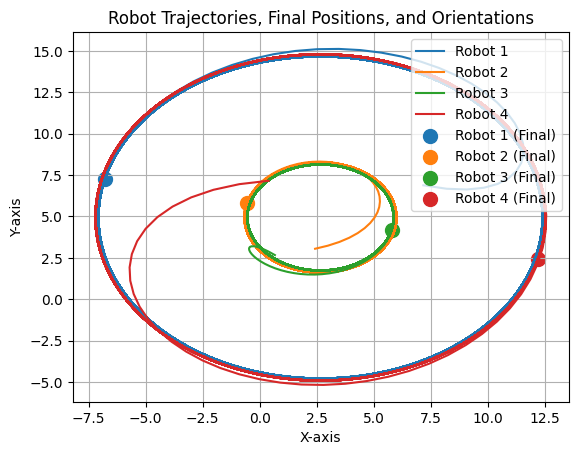

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Number of robots
num_robots = 4

# Define the reference distances between robots
reference_distances = np.array([[0, 1, 2, 3],
                                [1, 0, 1, 2],
                                [2, 1, 0, 1],
                                [3, 2, 1, 0]])

# Initialize robot positions randomly
robot_positions = np.random.uniform(0, 8, (2, num_robots))

# Store initial positions and orientations
trajectory = [robot_positions.copy()]
orientations = np.zeros(num_robots)

# Simulation parameters
num_steps = 5000
dt = 0.1
velocity_gain = 0.7
orientation_gain = 0.01  # Adjust this parameter to control the orientation change rate

# Function to calculate the angle between two vectors
def angle_between(v1, v2):
    return np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])

# Function to calculate circular trajectory
def circular_trajectory(radius, angular_speed, time):
    x = radius * np.cos(angular_speed * time)
    y = radius * np.sin(angular_speed * time)
    return np.array([x, y])

# Simulation loop
for step in range(num_steps):
    # Update robot positions using the velocity controller and circular motion
    for i in range(num_robots):
        for j in range(i + 1, num_robots):
            current_distance = np.linalg.norm(robot_positions[:, i] - robot_positions[:, j])
            error = current_distance - reference_distances[i, j]
            direction = (robot_positions[:, j] - robot_positions[:, i]) / current_distance
            velocity = velocity_gain * error * direction

            # Circular motion
            circular_radius = 0.5
            angular_speed = 1
            circular_position = circular_trajectory(circular_radius, angular_speed, step * dt)

            # Update robot positions with circular motion
            robot_positions[:, i] += velocity * dt / 2 + circular_position
            robot_positions[:, j] -= velocity * dt / 2 + circular_position

    # Store current positions in the trajectory
    trajectory.append(robot_positions.copy())

# Convert the trajectory list to a numpy array for convenience
trajectory = np.array(trajectory)

# Plot the trajectories
for i in range(num_robots):
    plt.plot(trajectory[:, 0, i], trajectory[:, 1, i], label=f'Robot {i + 1}')

# Plot final positions and orientations
for i in range(num_robots):
    plt.scatter(trajectory[-1, 0, i], trajectory[-1, 1, i], marker='o', s=100, label=f'Robot {i + 1} (Final)')


plt.title('Robot Trajectories, Final Positions, and Orientations')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()


**Patrolling**

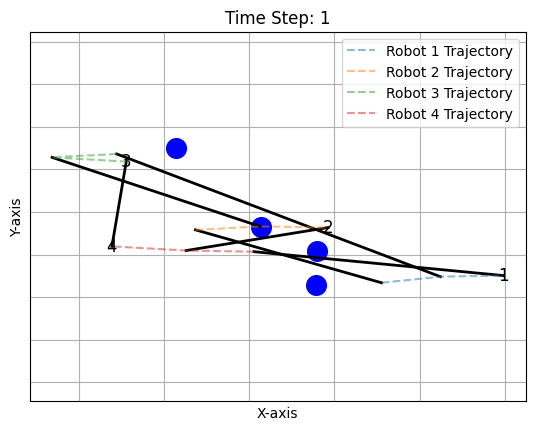

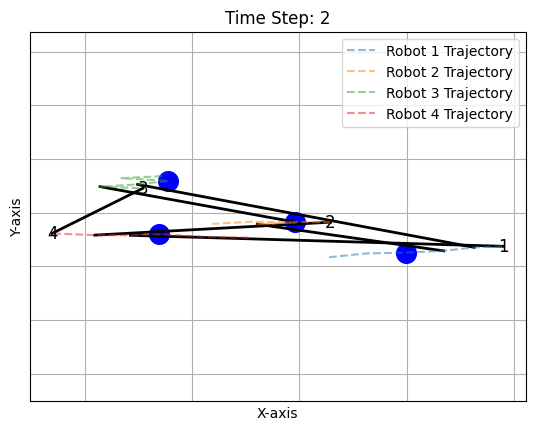

KeyboardInterrupt: ignored

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

# Number of robots
num_robots = 4

# Define the initial reference distances between robots
initial_reference_distances = np.array([[0, 1, 2, 3],
                                        [1, 0, 1, 2],
                                        [2, 1, 0, 1],
                                        [3, 2, 1, 0]])

# Initialize robot positions randomly
robot_positions = 10 * np.random.rand(2, num_robots)

# Create a fully connected graph
G = nx.complete_graph(num_robots)

# Assign initial reference distances as edge attributes
for i in range(num_robots):
    for j in range(i + 1, num_robots):
        G[i][j]["reference_distance"] = initial_reference_distances[i, j]

# Simulation parameters
num_steps = 300
dt = 0.1
velocity_gain = 0.9
circular_radius = 4
angular_speed = 0.1  # Adjust this parameter to control the circular motion speed
scaling_factor = 1  # Adjust this parameter to control the scaling rate

# Lists to store trajectories
x_trajectory = [[] for _ in range(num_robots)]
y_trajectory = [[] for _ in range(num_robots)]

# Simulation loop
for step in range(num_steps):
    plt.clf()  # Clear the previous plot

    # Draw nodes
    nx.draw_networkx_nodes(G, dict(enumerate(robot_positions.T)), node_size=200, node_color="b")

   #Update reference distances dynamically
    for i in range(num_robots):
        for j in range(i + 1, num_robots):
            G[i][j]["reference_distance"] = scaling_factor * step * dt

    # Update robot positions using the velocity controller and circular motion
    for i in range(num_robots):
        for j in range(i + 1, num_robots):
            current_distance = np.linalg.norm(robot_positions[:, i] - robot_positions[:, j])
            error = current_distance - G[i][j]["reference_distance"]
            direction = (robot_positions[:, j] - robot_positions[:, i]) / current_distance
            velocity = velocity_gain * error * direction

            # Circular motion
            circular_position = np.array([circular_radius * np.cos(angular_speed * step * dt),
                                          circular_radius * np.sin(angular_speed * step * dt)])

            # Update robot positions with velocity controller and circular motion
            robot_positions[:, i] += velocity * dt / 2 + circular_position
            robot_positions[:, j] -= velocity * dt / 2 + circular_position

            # Store positions for trajectory plotting
            x_trajectory[i].append(robot_positions[0, i])
            y_trajectory[i].append(robot_positions[1, i])

            x_trajectory[j].append(robot_positions[0, j])
            y_trajectory[j].append(robot_positions[1, j])

            # Draw edges with updated positions
            plt.plot([robot_positions[0, i], robot_positions[0, j]],
                     [robot_positions[1, i], robot_positions[1, j]], 'k-', linewidth=2)



    # Draw node labels
    node_labels = {i: str(i + 1) for i in G.nodes}
    nx.draw_networkx_labels(G, dict(enumerate(robot_positions.T)), labels=node_labels)

    # Plot trajectories
    for i in range(num_robots):
        plt.plot(x_trajectory[i], y_trajectory[i], linestyle='dashed', alpha=0.5, label=f'Robot {i + 1} Trajectory')

    # Add grid
    plt.grid(True)

    plt.title(f'Time Step: {step + 1}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.axis('equal')
    plt.legend()
    plt.pause(0.05)

plt.show()


**Offensive formation with the orientation consensus to provide decentralized orientation control**

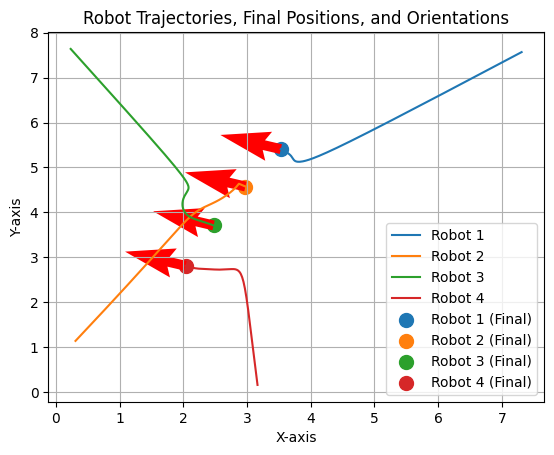

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Number of robots
num_robots = 4

# Define the reference distances between robots
reference_distances = np.array([[0, 1, 2, 3],
                                [1, 0, 1, 2],
                                [2, 1, 0, 1],
                                [3, 2, 1, 0]])

# Initialize robot positions randomly
robot_positions = np.random.uniform(0, 8, (2, num_robots))

# Store initial positions and orientations
trajectory = [robot_positions.copy()]
orientations = np.zeros(num_robots)
rotational_velocities = np.full(num_robots, 0.1)  # Adjust the rotational velocity as needed

# Simulation parameters
num_steps = 5000
dt = 0.1
velocity_gain = 0.7
orientation_gain = 0.1  # Adjust this parameter to control the orientation change rate

# Function to calculate the angle between two vectors
def angle_between(v1, v2):
    return np.arctan2(v2, 1) - np.arctan2(v1, 1)

# Simulation loop
for step in range(num_steps):
    # Update robot positions using the velocity controller
    for i in range(num_robots):
        for j in range(i + 1, num_robots):
            current_distance = np.linalg.norm(robot_positions[:, i] - robot_positions[:, j])
            error = current_distance - reference_distances[i, j]
            direction = (robot_positions[:, j] - robot_positions[:, i]) / current_distance
            velocity = velocity_gain * error * direction

            # Update robot positions
            robot_positions[:, i] += velocity * dt / 2
            robot_positions[:, j] -= velocity * dt / 2

    # Adjust the orientations towards the heading angle of final positions
    for i in range(num_robots):
        # Calculate the desired orientation based on the heading angle of the final position
        desired_orientation = np.arctan2(trajectory[-1][1, i] - robot_positions[1, i], trajectory[-1][0, i] - robot_positions[0, i])

        # Adjust the orientation towards the desired orientation
        orientations[i] += orientation_gain * (desired_orientation - orientations[i])

        # Update the orientation with rotational velocity
        orientations[i] += rotational_velocities[i] * dt

    # Store current positions in the trajectory
    trajectory.append(robot_positions.copy())

# Set the final orientation after error minimization as the initial orientation for each robot
initial_orientations = orientations.copy()


# Continue adjusting orientations until they are equal and reach the average
while not np.allclose(orientations, np.mean(orientations)):
    # Adjust the orientations towards the average orientation
    orientations += orientation_gain * (np.mean(initial_orientations) - orientations)

    # Update the orientation with rotational velocity
    orientations += rotational_velocities * dt
    orientations += math.pi/4
    # Store current positions in the trajectory
    trajectory.append(robot_positions.copy())

# Convert the trajectory list to a numpy array for convenience
trajectory = np.array(trajectory)

# Plot the trajectories
for i in range(num_robots):
    plt.plot(trajectory[:, 0, i], trajectory[:, 1, i], label=f'Robot {i + 1}')

# Plot final positions and orientations
for i in range(num_robots):
    plt.scatter(trajectory[-1, 0, i], trajectory[-1, 1, i], marker='o', s=100, label=f'Robot {i + 1} (Final)')
    plt.quiver(trajectory[-1, 0, i], trajectory[-1, 1, i],
               np.cos(orientations[i]), np.sin(orientations[i]),
               angles='xy', scale_units='xy', scale=1, color="r", width=0.02, headwidth=3)

plt.title('Robot Trajectories, Final Positions, and Orientations')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()


**Defensive formation with collision avoidance and orientation consensus**

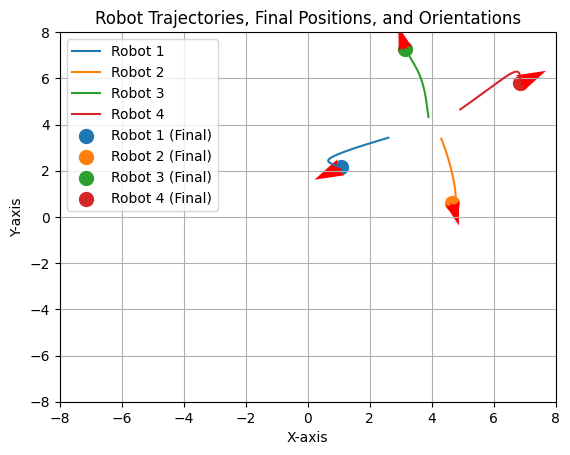

In [ ]:


import matplotlib.pyplot as plt
import numpy as np
import math

# Number of robots
num_robots = 4

reference_distances= np.array([[0, 5, math.sqrt(50), 5],
                                          [5, 0, 5, math.sqrt(50)],
                                          [math.sqrt(50), 5, 0, 5],
                                          [5, math.sqrt(50), 5, 0]])

# Initialize robot positions randomly
robot_positions = np.random.uniform(0, 5, (2, num_robots))

# Store initial positions and orientations
trajectory = [robot_positions.copy()]
orientations = np.zeros(num_robots)
rotational_velocities = np.full(num_robots, 0.1)  # Adjust the rotational velocity as needed

# Simulation parameters
num_steps = 1000
dt = 0.1
velocity_gain = 0.5
orientation_gain = 0.1  # Adjust this parameter to control the orientation change rate
collision_threshold = 0.4 # Minimum distance for collision avoidance

# Function to calculate the angle between two vectors
def angle_between(v1, v2):
    return np.arctan2(v2, 1) - np.arctan2(v1, 1)

# Function to calculate the repulsive force between two robots
def repulsive_force(distance):
    if distance < collision_threshold:
        return -1.0 / distance  # Repulsive force increases as distance decreases
    else:
        return 0.0

# Simulation loop
for step in range(num_steps):
    # Update robot positions using the velocity controller
    for i in range(num_robots):
        for j in range(i + 1, num_robots):
            current_distance = np.linalg.norm(robot_positions[:, i] - robot_positions[:, j])
            error = current_distance - reference_distances[i, j]
            direction = (robot_positions[:, j] - robot_positions[:, i]) / current_distance
            velocity = velocity_gain * error * direction

            # Add repulsive force for collision avoidance
            repulsion = repulsive_force(current_distance)
            velocity += repulsion * direction

            # Update robot positions
            robot_positions[:, i] += velocity * dt / 2
            robot_positions[:, j] -= velocity * dt / 2

    # Adjust the orientations towards the error direction
    for i in range(num_robots):
        neighbor_indices = [j for j in range(num_robots) if j != i]
        neighbor_positions = robot_positions[:, neighbor_indices]

        # Calculate the error direction from the current robot to its neighbors
        error_direction = np.angle(np.mean(np.exp(1j * (neighbor_positions - robot_positions[:, i][:, np.newaxis]))))

        # Adjust the orientation towards the error direction
        orientations[i] += orientation_gain * (error_direction - orientations[i])

        # Update the orientation with rotational velocity
        orientations[i] += rotational_velocities[i] * dt

    # Store current positions in the trajectory
    trajectory.append(robot_positions.copy())

# Convert the trajectory list to a numpy array for convenience
trajectory = np.array(trajectory)

# Calculate the final orientation based on the last positions
graph_center = np.mean(robot_positions, axis=1)
final_orientations = np.arctan2(robot_positions[1, :] - graph_center[1], robot_positions[0, :] - graph_center[0])

# Update robot orientations
robot_orientations = final_orientations

# Plot the trajectories
for i in range(num_robots):
    plt.plot(trajectory[:, 0, i], trajectory[:, 1, i], label=f'Robot {i + 1}')

# Plot final positions and orientations
for i in range(num_robots):
    plt.scatter(trajectory[-1, 0, i], trajectory[-1, 1, i], marker='o', s=100, label=f'Robot {i + 1} (Final)')
    plt.quiver(trajectory[-1, 0, i], trajectory[-1, 1, i],
               np.cos(final_orientations[i]), np.sin(final_orientations[i]),
               angles='xy', scale_units='xy', scale=1, color="r", width=0.02, headwidth=3)

plt.title('Robot Trajectories, Final Positions, and Orientations')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.xlim(-8, 8)  # Adjust these values based on your requirement
plt.ylim(-8, 8)
plt.show()
